In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.fs as fs
#import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
import pandas as pd
import pyarrow as pa
from pyarrow import parquet as pq
from pyarrow import fs

# üîê lakeFS credentials
ACCESS_KEY = "access_key"
SECRET_KEY = "secret_key"
lakefs_endpoint = "http://lakefs-dev:8000/"

# ‚úÖ ‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠ FileSystem ‡∏Ç‡∏≠‡∏á LakeFS
s3 = fs.S3FileSystem(
    access_key=ACCESS_KEY, 
    secret_key=SECRET_KEY, 
    endpoint_override=lakefs_endpoint
)

# ‚úÖ ‡∏£‡∏∞‡∏ö‡∏∏ Path ‡∏´‡∏•‡∏±‡∏Å
base_path = 'weather/main/weather.parquet/year=2025/month=5/'

# ‚úÖ ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
days = [12, 13, 14, 15]

# ‚úÖ ‡∏™‡∏£‡πâ‡∏≤‡∏á List ‡πÄ‡∏Å‡πá‡∏ö DataFrame
df_list = []

# ‚úÖ ‡∏≠‡πà‡∏≤‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏≤‡∏Å‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏ß‡∏±‡∏ô‡πÅ‡∏•‡∏∞‡∏£‡∏ß‡∏°‡πÄ‡∏õ‡πá‡∏ô DataFrame
for day in days:
    path = f"{base_path}day={day}/"
    print(f"Loading data from: {path}")
    
    # ‡∏≠‡πà‡∏≤‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Parquet
    dataset = pq.ParquetDataset(path, filesystem=s3)
    
    # ‡∏≠‡πà‡∏≤‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Schema ‡∏Ç‡∏≠‡∏á dataset
    schema = dataset.schema
    
    # ‚úÖ ‡πÅ‡∏õ‡∏•‡∏á Schema ‡πÉ‡∏´‡πâ‡πÄ‡∏õ‡πá‡∏ô float64 ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ó‡∏∏‡∏Å‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô float32 ‡∏´‡∏£‡∏∑‡∏≠ int64
    fields = []
    for i in range(len(schema)):
        field = schema.field(i)
        if isinstance(field.type, pa.FloatArray) or field.type == pa.float32():
            fields.append(pa.field(field.name, pa.float64()))  # ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô float64
        elif field.type == pa.int64():  # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ä‡∏ô‡∏¥‡∏î int64
            fields.append(pa.field(field.name, pa.float64()))  # ‡πÅ‡∏õ‡∏•‡∏á int64 ‡πÄ‡∏õ‡πá‡∏ô float64
        else:
            fields.append(field)
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á Schema ‡πÉ‡∏´‡∏°‡πà‡∏à‡∏≤‡∏Å fields ‡∏ó‡∏µ‡πà‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡πÅ‡∏•‡πâ‡∏ß
    new_schema = pa.schema(fields)
    
    # ‡∏≠‡πà‡∏≤‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÅ‡∏•‡∏∞‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô DataFrame
    try:
        table = dataset.read().cast(new_schema)
        df = table.to_pandas()
    except Exception as e:
        print(f"Error reading {path}: {e}")
        continue
    
    # ‚úÖ ‡πÄ‡∏û‡∏¥‡πà‡∏° DataFrame ‡∏•‡∏á‡πÉ‡∏ô List
    df_list.append(df)

# ‚úÖ ‡∏£‡∏ß‡∏°‡∏ó‡∏∏‡∏Å DataFrame ‡πÄ‡∏Ç‡πâ‡∏≤‡∏î‡πâ‡∏ß‡∏¢‡∏Å‡∏±‡∏ô
final_df = pd.concat(df_list, ignore_index=True)

# ‚úÖ ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
print(final_df.info())
print(final_df.head())
print(f"Total Records Loaded: {len(final_df)}")

Loading data from: weather/main/weather.parquet/year=2025/month=5/day=12/
Loading data from: weather/main/weather.parquet/year=2025/month=5/day=13/
Loading data from: weather/main/weather.parquet/year=2025/month=5/day=14/
Loading data from: weather/main/weather.parquet/year=2025/month=5/day=15/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174471 entries, 0 to 174470
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype                       
---  ------               --------------   -----                       
 0   timestamp            174471 non-null  datetime64[ns]              
 1   minute               174471 non-null  float64                     
 2   created_at           174471 non-null  datetime64[ns, Asia/Bangkok]
 3   district             174471 non-null  object                      
 4   province             174471 non-null  object                      
 5   location             174471 non-null  object                      
 6   weather_main

In [3]:
print(final_df.select_dtypes(include=['object']).columns)

Index(['district', 'province', 'location', 'weather_main',
       'weather_description'],
      dtype='object')


In [4]:
# üîç ‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡πÄ‡∏â‡∏û‡∏≤‡∏∞‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç
final_df = final_df.select_dtypes(include=['float64', 'int64'])

In [5]:
pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


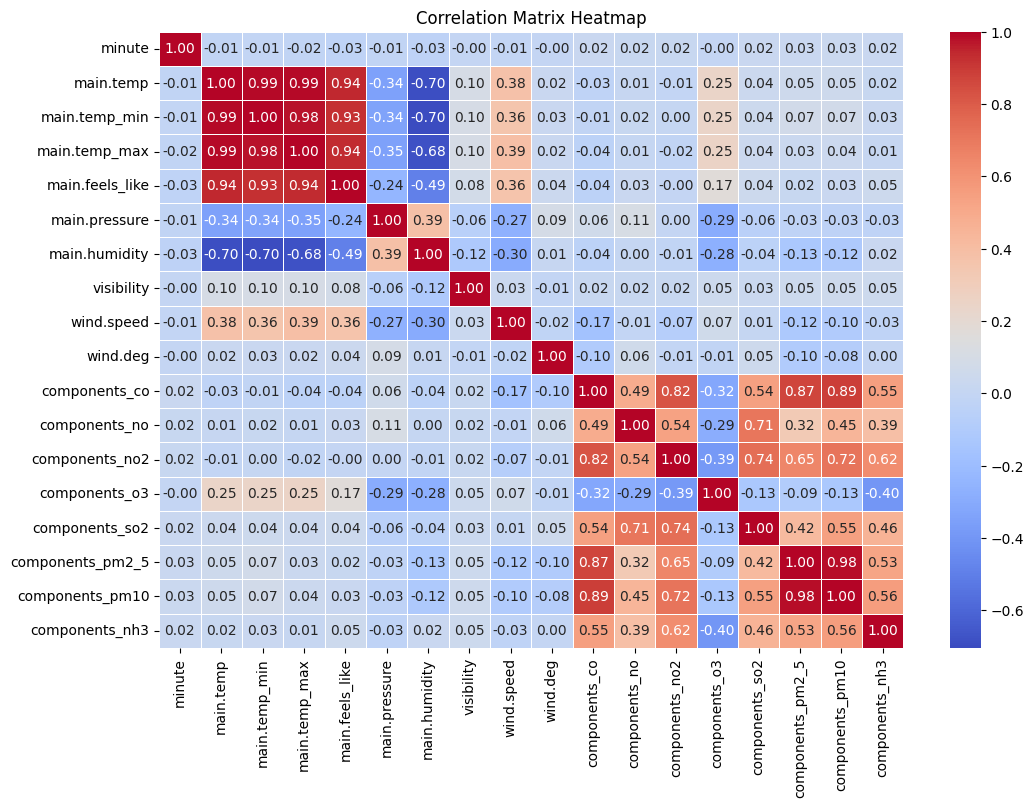

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# ‚úÖ ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì Correlation Matrix
corr_matrix = final_df.corr()

# ‚úÖ ‡∏ß‡∏≤‡∏î Heatmap ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [7]:
pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
target_variable = 'components_pm2_5'

# ‚úÖ ‡∏Å‡∏≥‡∏´‡∏ô‡∏î features
features = final_df.drop(columns=[target_variable])

# ‚úÖ ‡∏•‡∏ö‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡∏°‡∏µ NaN
features = features.dropna(axis=1)

# ‚úÖ ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö NaN
print(features.isnull().sum())

# ‚úÖ ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì mutual information
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(features, final_df[target_variable])

# ‚úÖ ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
mi_scores = pd.DataFrame(mutual_info, index=features.columns, columns=["Mutual Information"])
print(mi_scores.sort_values(by="Mutual Information", ascending=False))


minute             0
main.temp          0
main.temp_min      0
main.temp_max      0
main.feels_like    0
main.pressure      0
main.humidity      0
wind.speed         0
wind.deg           0
components_co      0
components_no      0
components_no2     0
components_o3      0
components_so2     0
components_pm10    0
components_nh3     0
dtype: int64
                 Mutual Information
components_co              7.397628
components_o3              6.103125
components_pm10            5.969033
components_no2             5.056435
components_nh3             4.489091
components_so2             3.687449
wind.speed                 2.950685
components_no              2.823897
wind.deg                   2.667514
main.temp_min              1.474644
main.temp_max              1.465190
main.temp                  1.416667
main.feels_like            1.372790
main.humidity              0.923721
main.pressure              0.564261
minute                     0.268676


In [11]:
from sklearn.feature_selection import mutual_info_regression

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì Mutual Information
mutual_info = mutual_info_regression(features, final_df[target_variable])

# ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
mi_scores = pd.DataFrame(mutual_info, index=features.columns, columns=["Mutual Information"])

# ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
print(mi_scores.sort_values(by="Mutual Information", ascending=False))

                 Mutual Information
components_co              7.396108
components_o3              6.099895
components_pm10            5.971055
components_no2             5.057679
components_nh3             4.492712
components_so2             3.688193
wind.speed                 2.950727
components_no              2.824304
wind.deg                   2.665014
main.temp_min              1.474459
main.temp_max              1.465088
main.temp                  1.415497
main.feels_like            1.374081
main.humidity              0.924061
main.pressure              0.564382
minute                     0.267712


In [12]:
from sklearn.feature_selection import SelectKBest

# ‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏±‡∏°‡∏û‡∏±‡∏ô‡∏ò‡πå‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î K ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£
k_best = SelectKBest(mutual_info_regression, k=9)
X_new = k_best.fit_transform(features, final_df[target_variable])

# ‡∏î‡∏π‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡πÄ‡∏•‡∏∑‡∏≠‡∏Å
selected_features = features.columns[k_best.get_support()]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['wind.speed', 'wind.deg', 'components_co', 'components_no',
       'components_no2', 'components_o3', 'components_so2', 'components_pm10',
       'components_nh3'],
      dtype='object')


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ‚úÖ ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô Training ‡πÅ‡∏•‡∏∞ Test set
X = features  # ‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
y = final_df[target_variable]  # ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£‡πÄ‡∏õ‡πâ‡∏≤‡∏´‡∏°‡∏≤‡∏¢

# ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô 80% Training ‡πÅ‡∏•‡∏∞ 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ‚úÖ ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏• Linear Regression
model = LinearRegression()

# ‚úÖ ‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•
model.fit(X_train, y_train)

# ‚úÖ ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ú‡∏•‡∏à‡∏≤‡∏Å Test Set
y_pred = model.predict(X_test)

# ‚úÖ ‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡∏ú‡∏•‡πÇ‡∏°‡πÄ‡∏î‡∏•
mse = mean_squared_error(y_test, y_pred)  # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì MSE
r2 = r2_score(y_test, y_pred)  # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì R-squared

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.8832294419279678
R-squared: 0.9892483487127427


In [15]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (174471, 16)
y shape:  (174471,)


In [16]:
# ‚úÖ ‡∏•‡∏ö‡πÅ‡∏ñ‡∏ß‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡πà‡∏≤ NaN ‡πÉ‡∏ô‡∏ó‡∏±‡πâ‡∏á X ‡πÅ‡∏•‡∏∞ y
X_clean = X.dropna()
y_clean = y[X_clean.index]  # ‡πÉ‡∏´‡πâ index ‡∏Ç‡∏≠‡∏á y ‡∏ï‡∏£‡∏á‡∏Å‡∏±‡∏ö X ‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡∏°‡∏µ NaN

print("Cleaned X shape: ", X_clean.shape)
print("Cleaned y shape: ", y_clean.shape)

Cleaned X shape:  (174471, 16)
Cleaned y shape:  (174471,)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ‚úÖ ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Train ‡πÅ‡∏•‡∏∞ Test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# ‚úÖ ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏• Linear Regression
regressor = LinearRegression()

# ‚úÖ ‡πÄ‡∏ó‡∏£‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏•
regressor.fit(X_train, y_train)

# ‚úÖ ‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
y_pred = regressor.predict(X_test)

# ‚úÖ ‡πÅ‡∏™‡∏î‡∏á Coefficients
print("Model Coefficients:")
print(regressor.coef_)

Model Coefficients:
[-8.27980200e-04  2.37337894e-01  1.69425697e-01 -2.88450596e-01
 -6.64203075e-02  1.00452926e-01 -3.95705264e-03 -2.88507840e-02
  2.98952272e-04  3.40204890e-03 -3.78421750e-01 -3.85784039e-02
  1.39061797e-02 -6.22400952e-01  9.18003891e-01  6.68584694e-02]


                 Coefficient
components_pm10     0.918004
main.temp           0.237338
main.temp_min       0.169426
main.pressure       0.100453
components_nh3      0.066858
components_o3       0.013906
components_co       0.003402
wind.deg            0.000299
minute             -0.000828
main.humidity      -0.003957
wind.speed         -0.028851
components_no2     -0.038578
main.feels_like    -0.066420
main.temp_max      -0.288451
components_no      -0.378422
components_so2     -0.622401


/tmp/ipykernel_32837/2039268495.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.index, y=coefficients['Coefficient'], palette='coolwarm')


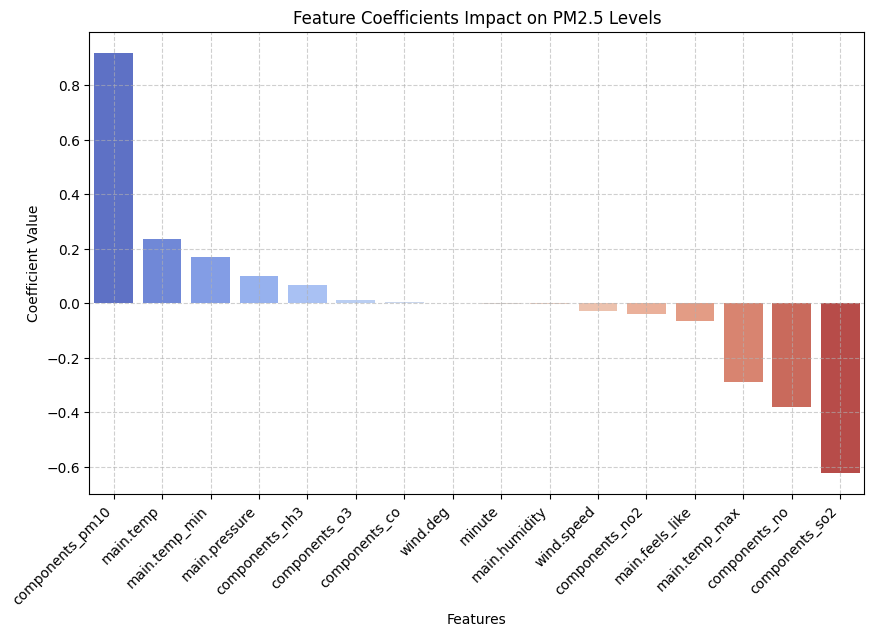

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ‚úÖ ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå‡∏Ç‡∏≠‡∏á Coefficients
coefficients = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])

# ‚úÖ ‡πÄ‡∏£‡∏µ‡∏¢‡∏á‡∏•‡∏≥‡∏î‡∏±‡∏ö‡∏à‡∏≤‡∏Å‡∏Ñ‡πà‡∏≤‡∏°‡∏≤‡∏Å‡πÑ‡∏õ‡∏ô‡πâ‡∏≠‡∏¢
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# ‚úÖ ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•
print(coefficients)

# ‚úÖ Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.index, y=coefficients['Coefficient'], palette='coolwarm')
plt.title('Feature Coefficients Impact on PM2.5 Levels')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [19]:
# ‡πÅ‡∏¢‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô X (‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå) ‡πÅ‡∏•‡∏∞ y (‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£‡∏ó‡∏µ‡πà‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢)
#X = features  # ‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
#y = final_df[target_variable]  # ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£ PM2.5 ‡∏ó‡∏µ‡πà‡πÄ‡∏£‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
X = final_df[['components_pm10', 'main.temp', 'wind.speed', 'main.humidity', 'main.pressure' ]]  # ‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå
y = final_df['components_pm2_5']  # ‡∏ï‡∏±‡∏ß‡πÅ‡∏õ‡∏£‡∏ó‡∏µ‡πà‡πÄ‡∏£‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ (PM2.5)

In [20]:
from sklearn.model_selection import train_test_split

# ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏≠‡∏≠‡∏Å‡πÄ‡∏õ‡πá‡∏ô training set ‡πÅ‡∏•‡∏∞ test set (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
from sklearn.linear_model import LinearRegression
# ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏• Linear Regression
regressor = LinearRegression()
# ‡∏ù‡∏∂‡∏Å‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏Å‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• training set
regressor.fit(X_train, y_train)

LinearRegression()

In [23]:
# ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ñ‡πà‡∏≤‡∏ù‡∏∏‡πà‡∏ô PM2.5 ‡πÉ‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö
y_pred = regressor.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì R¬≤ (‡∏Ñ‡πà‡∏≤ R-squared) ‡πÅ‡∏•‡∏∞ Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R¬≤ (Coefficient of Determination): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

R¬≤ (Coefficient of Determination): 0.9662
Mean Absolute Error (MAE): 1.2684


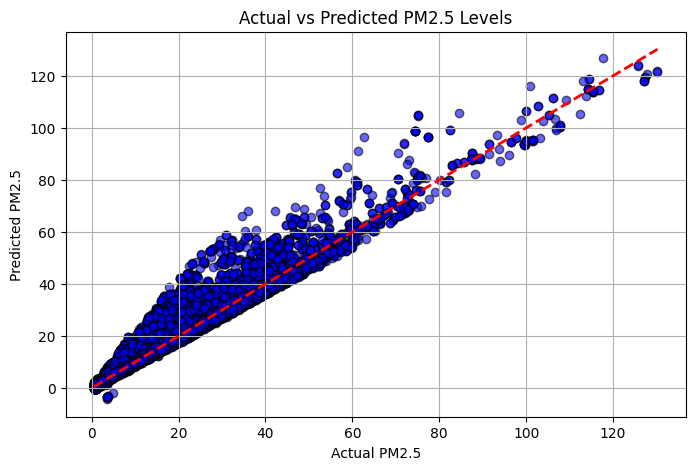

In [25]:
import matplotlib.pyplot as plt

# Visualization: Actual vs Predicted Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted PM2.5 Levels')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.grid(True)
plt.show()

In [26]:
pip install statsmodels

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10.4/10.4 MB 14.3 MB/s eta 0:00:0000:010:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232.9/232.9 kB 25.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


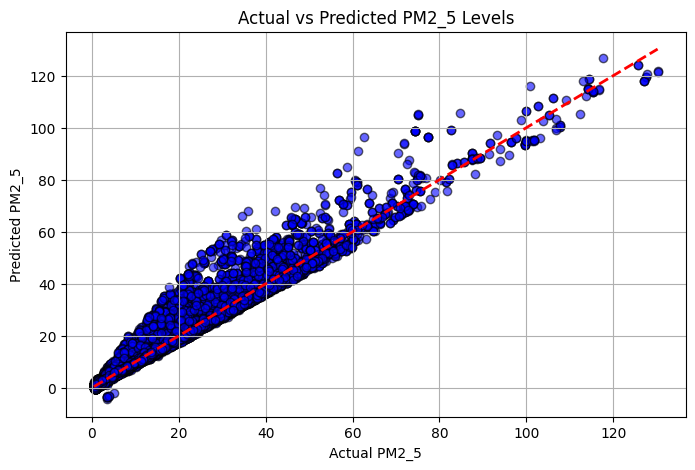

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ‚úÖ 6. Visualization
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted PM2_5 Levels')
plt.xlabel('Actual PM2_5')
plt.ylabel('Predicted PM2_5')
plt.grid(True)
plt.show()